In [40]:
import glob

import numpy as np
from pylab import *


def read_ps_voltage(file):
    read_data = np.genfromtxt(file, skip_header=1, delimiter=',')
    return read_data[:, 1]

# Messungen

Wir haben angefangen 20 verschiedene Entfernungen zu messen und diese mit der Picoscope Software in 20 einzelne CSV Dateien gespeichert.


In [41]:
files = glob.glob("cleaned/*cm*.csv")

# [reference in mm, all voltage values]
data = {
    100: read_ps_voltage(files[0]),
    130: read_ps_voltage(files[1]),
    160: read_ps_voltage(files[2]),
    180: read_ps_voltage(files[3]),
    220: read_ps_voltage(files[4]),
    245: read_ps_voltage(files[5]),
    250: read_ps_voltage(files[6]),
    280: read_ps_voltage(files[7]),
    300: read_ps_voltage(files[8]),
    340: read_ps_voltage(files[9]),
    380: read_ps_voltage(files[10]),
    410: read_ps_voltage(files[11]),
    460: read_ps_voltage(files[12]),
    490: read_ps_voltage(files[13]),
    520: read_ps_voltage(files[14]),
    580: read_ps_voltage(files[15]),
    620: read_ps_voltage(files[16]),
    650: read_ps_voltage(files[17]),
    690: read_ps_voltage(files[18]),
    710: read_ps_voltage(files[19]),
}

data_mean = {k: np.mean(v) for k, v in data.items()}

measurements = np.array(list(data_mean.items()))
distances = measurements[:, 0]
voltages = measurements[:, 1]

# Plotten und Logarithm

Wir können jetzt diese daten plotten. Sie haben die form $y = x^a$ deswegen müssen wir sie logarithmieren.


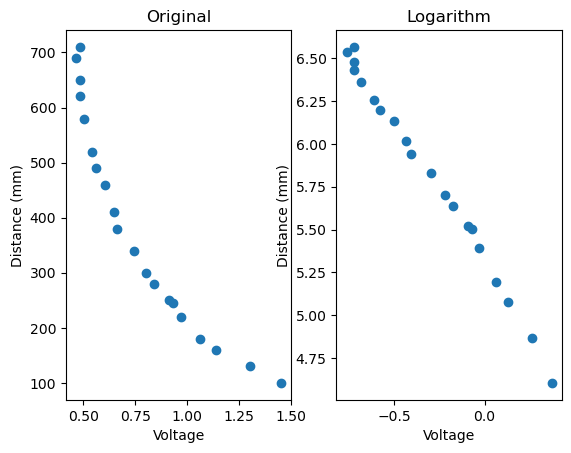

In [42]:
subplot(1, 2, 1)
scatter(voltages, distances)

title("Original")
ylabel("Distance (mm)")
xlabel("Voltage")

log_distances = np.log(distances)
log_voltages = np.log(voltages)

subplot(1, 2, 2)
scatter(log_voltages, log_distances)

title("Logarithm")
ylabel("Distance (mm)")
xlabel("Voltage")

show()

# Lineare Regression

Jetzt können wir für die lineare Regression $a$ und $b$ berechnen.

Wir verwenden:

$a=\frac{\sum_{i=1}^{n}(x_i-\bar{x})*(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$ und $b=\bar{y}-a*\bar{x}$


In [43]:
x = log_voltages
y = log_distances

x_mean = np.mean(x)
y_mean = np.mean(y)

a = np.divide(np.sum((x - x_mean) * (y - y_mean)),
              np.sum((x - x_mean) ** 2))

b = y_mean - a * x_mean

print("a =", a)
print("b =", b)

a = -1.6176265365895715
b = 5.307953531893156


Das plotten wir noch.


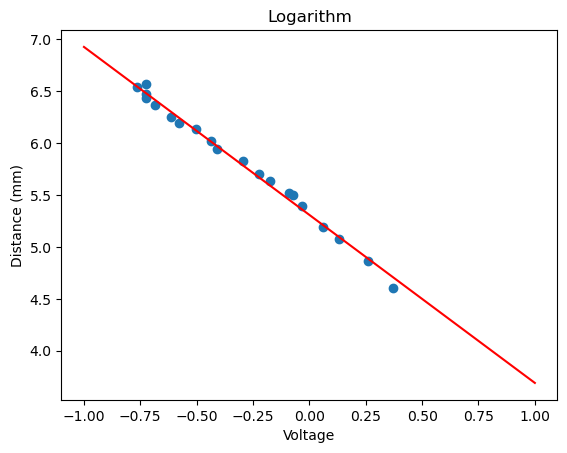

In [44]:
lin = np.linspace(-1, 1)
y_lin = a * lin + b

figure()

scatter(log_voltages, log_distances)
plot(lin, y_lin, 'r')

title("Logarithm")
ylabel("Distance (mm)")
xlabel("Voltage")
show()

Wir rechnen die lineare regression in eine exponentielle regression um indem wir $y = e^b * x^a$ anwenden.


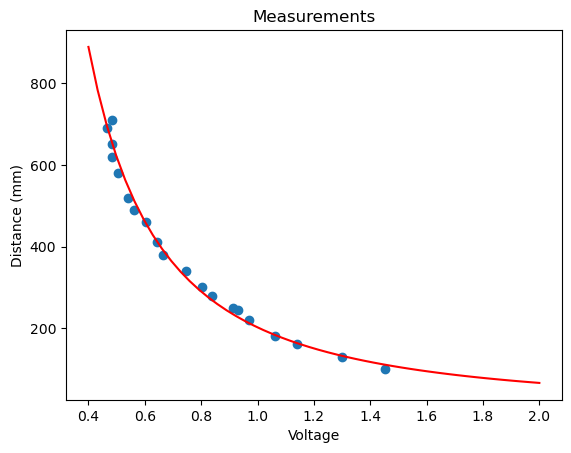

In [45]:
def exp_regression(x):
    return np.exp(b) * x ** a

xc = np.linspace(0.4, 2)
yc = exp_regression(xc)

figure()

scatter(voltages, distances)
plot(xc, yc, 'r')

title("Measurements")
ylabel("Distance (mm)")
xlabel("Voltage")
show()

# Fehlerrechnung


In [46]:
# wahrer wert
dina4_breite_mm = 210

# gemessene werte
measured_dina4_breite = read_ps_voltage("./cleaned/dina4_breite_cleaned.csv")
measured_dina4_breite_v = { "data": measured_dina4_breite }

measured_dina4_breite_v["mean"] = np.mean(measured_dina4_breite_v["data"])
measured_dina4_breite_v["std"] = np.std(measured_dina4_breite_v["data"])
measured_dina4_breite_v["stdmean"] = measured_dina4_breite_v["std"] / np.sqrt(measured_dina4_breite_v["data"].size)


def stdmean(x):
    return np.std(x) / np.sqrt(x.size)

## Messfehler


### 68 % Vertrauensbereich


In [47]:
gauss_68 = measured_dina4_breite_v["stdmean"] * 1.03
print("+-", str(gauss_68), "V")

def sicherheit_65(x):
    return (np.mean(x) + 1.03 * stdmean(x), np.mean(x) - 1.03 * stdmean(x))

print(sicherheit_65(measured_dina4_breite))

+- 0.00021814891029989423 V
(0.9879949433436997, 0.9875586455230999)


### 95 % Vertrauensbereich


In [48]:
gauss_95 = 2*measured_dina4_breite_v["stdmean"] * 2.09
print("+-", str(gauss_95), "V")

def sicherheit_95(x):
    return (np.mean(x) + 2.09 * stdmean(x), np.mean(x) - 2.09 * stdmean(x))

print(sicherheit_95(measured_dina4_breite))

+- 0.000885303344712192 V
(0.988219446105756, 0.9873341427610437)


In [49]:
# 04-13 verwenden
measured_breite = exp_regression(measured_dina4_breite_v["mean"])
delta_a = measured_breite - dina4_breite_mm
print("delta_a =", delta_a, "mm")

delta_a = -4.00581307500218 mm


## Flächenmessung

Ein DIN A4 Blatt hat das Format $297 mm * 210 mm$

Die fläche sollte $62370mm^2$.


In [50]:
estimated_width = exp_regression(measured_dina4_breite_v["mean"])
estimated_height = estimated_width * 1.4142 
flaeche = estimated_width * estimated_height
print("Fläche:", flaeche, "mm^2")
# höhe messunge verwenden
# Fehlerfortpflanzungsgesetz

Fläche: 60009.60425731316 mm^2
